In [1]:
from BEAR.Env.env_building  import BuildingEnvReal
from BEAR.Controller.MPC_Controller import MPCAgent
from BEAR.Utils.utils_building import ParameterGenerator,get_user_input, Getroominfor
from BEAR.Customize.reward_functions import my_custom_reward_function3
import numpy as np
import functools
import datetime
import os
import time
from collections import deque
import matplotlib.pyplot as plt
import importlib
from BEAR.Env import env_building
from BEAR.Controller import MPC_Controller
from BEAR.Utils import utils_building
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from stable_baselines3 import PPO
import os
from stable_baselines3 import PPO ,DQN,DDPG, SAC, A2C
from stable_baselines3.common.logger import configure
from stable_baselines3.ppo import MlpPolicy
# from stable_baselines.bench import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.env_util import make_vec_env
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns




We use OfficeSmall as the building environment to test. In the cell below we use the dictionary to get the file names for getting room info such as number of rooms.

In [2]:

Building_dic = {
    'ApartmentHighRise': ('ASHRAE901_ApartmentHighRise_STD2019_Tucson.table.htm', [6.299, 3.285, 0.384, 0.228, 3.839, 0.287, 2.786]),
    'ApartmentMidRise': ('ASHRAE901_ApartmentMidRise_STD2019_Tucson.table.htm', [6.299, 3.285, 0.384, 0.228, 3.839, 0.287, 2.786]),
    'Hospital': ('ASHRAE901_Hospital_STD2019_Tucson.table.htm', [6.299, 3.839, 0.984, 0.228, 3.839, 3.285, 2.615]),
    'HotelLarge': ('ASHRAE901_HotelLarge_STD2019_Tucson.table.htm', [6.299, 0.228, 0.984, 0.228, 0.228, 2.705, 2.615]),
    'HotelSmall': ('ASHRAE901_HotelSmall_STD2019_Tucson.table.htm', [6.299, 3.839, 0.514, 0.228, 3.839, 0.1573, 2.615]),
    'OfficeLarge': ('ASHRAE901_OfficeLarge_STD2019_Tucson.table.htm', [6.299, 3.839, 0.984, 0.228, 4.488, 3.839, 2.615]),
    'OfficeMedium': ('ASHRAE901_OfficeMedium_STD2019_Tucson.table.htm', [6.299, 3.839, 0.514, 0.228, 4.488, 0.319, 2.615]),
    'OfficeSmall': ('ASHRAE901_OfficeSmall_STD2019_Tucson.table.htm', [6.299, 3.839, 0.514, 0.228, 4.488, 0.319, 2.615]),
    'OutPatientHealthCare': ('ASHRAE901_OutPatientHealthCare_STD2019_Tucson.table.htm', [6.299, 3.839, 0.514, 0.228, 3.839, 0.5650E-02, 2.615]),
    'RestaurantFastFood': ('ASHRAE901_RestaurantFastFood_STD2019_Tucson.table.htm', [6.299, 0.158, 0.547, 4.706, 0.158, 0.350, 2.557]),
    'RestaurantSitDown': ('ASHRAE901_RestaurantSitDown_STD2019_Tucson.table.htm', [6.299, 0.158, 0.514, 4.706, 0.158, 0.194, 2.557]),
    'RetailStandalone': ('ASHRAE901_RetailStandalone_STD2019_Tucson.table.htm', [6.299, 0.047, 0.984, 0.228, 0.228, 0.047, 3.695]),
    'RetailStripmall': ('ASHRAE901_RetailStripmall_STD2019_Tucson.table.htm', [6.299, 0.1125, 0.514, 0.228, 0.228, 0.1125, 3.695]),
    'SchoolPrimary': ('ASHRAE901_SchoolPrimary_STD2019_Tucson.table.htm', [6.299, 0.144, 0.514, 0.228, 0.228, 0.144, 2.672]),
    'SchoolSecondary': ('ASHRAE901_SchoolSecondary_STD2019_Tucson.table.htm', [6.299, 3.839, 0.514, 0.228, 3.839, 0.144, 2.672]),
    'Warehouse': ('ASHRAE901_Warehouse_STD2019_Tucson.table.htm', [0.774, 0.1926, 1.044, 0.5892, 10.06, 0.1926, 2.557])}
root='BEAR/Data/'
Building='OfficeSmall'
filename = root+Building_dic[Building][0]
Layerall, roomnum, buildall = Getroominfor(filename)

zones = [row[0] for row in buildall]
print(zones)



['CORE_ZN', 'PERIMETER_ZN_1', 'PERIMETER_ZN_2', 'PERIMETER_ZN_3', 'PERIMETER_ZN_4', 'ATTIC']


Here we initialize the environment for testing. It takes a random action for 48 hours. 

Though we tested for 3 different reward functions for the longer version of the paper, we keep only one (reward=3) for the shorter version published in e-Energy. 
This is the reward function that is identical to the original version of the BEAR paper.

In [3]:
reward=3

Parameter_dict=ParameterGenerator(Building,'Hot_Dry','Tucson')  #Description of ParameterGenerator in bldg_utils.py
#Create environment
env = BuildingEnvReal(Parameter_dict, user_reward_function=my_custom_reward_function3)

env.Stochasticity=False
env.Stochasticity_Level=0
numofhours=48
#Initialize with user-defined indoor temperature
env.reset()
for i in range(numofhours):
    a = env.action_space.sample()#Randomly select an action
    obs, r, terminated, truncated, info = env.step(a)#Return observation and reward
    print(obs)
RandomController_state=env.statelist #Collect the state list
RandomController_action=env.actionlist #Collect the action list
env._get_info()

###############All Zones from Ground############
CORE_ZN  [Zone index]:  0
PERIMETER_ZN_1  [Zone index]:  1
PERIMETER_ZN_2  [Zone index]:  2
PERIMETER_ZN_3  [Zone index]:  3
PERIMETER_ZN_4  [Zone index]:  4
ATTIC  [Zone index]:  5
###################################################
occupancy_csv head:                      Step  PERIMETER_ZN_1  CORE_ZN  ATTIC  PERIMETER_ZN_2  \
Time                                                                        
2021-01-01 00:00:00   2.5             0.0      0.0    0.0             0.0   
2021-01-01 01:00:00   8.5             0.0      0.0    0.0             0.0   
2021-01-01 02:00:00  14.5             0.0      0.0    0.0             0.0   
2021-01-01 03:00:00  20.5             0.0      0.0    0.0             0.0   
2021-01-01 04:00:00  26.5             0.0      0.0    0.0             0.0   

                     PERIMETER_ZN_3  PERIMETER_ZN_4  Whole building  \
Time                                                                  
2021-01-01 00:0

{'zone_temperature': array([ 9.69055006,  8.23110472, 20.51878202, 15.01911875,  9.38052148,
        17.29845396]),
 'reward_breakdown': {'comfort_level': 0.0, 'power_consumption': 0.0}}

### Reinforcement Learning

First, we define the function for calculating temperature deviations. This differs for each reward function. For reward 3, it is basically the absolute difference from the target temperature which is assumed to be 22 across the simulation run.

In [5]:
from BEAR.Customize.reward_functions import my_custom_reward_function3
def calculate_temperature_deviations(state_new, occ_info, roomnum, target=22):
    """
    Calculate temperature deviations based on occupancy and target temperatures.

    Parameters:
        state_new (numpy array): The array of new state temperatures for each zone.
        occ_info (numpy array): Occupancy information for each zone.
        roomnum (int): The number of zones (rooms).
        target (float): The target temperature around which deviations are measured.

    Returns:
        numpy array: An array of temperature deviations for each zone.
    """

    # Calculate temperature deviations
    temp_dev_array =np.abs(state_new[:roomnum] - target) 

    return temp_dev_array
#Create environment
env = BuildingEnvReal(Parameter_dict,user_reward_function=my_custom_reward_function3)


Length of stochastic occu bin: 8760
Number of nan values in stochastic occu bin: 0


### Training SAC and PPO with Deterministic Reward
Running the cell below would allow you to train SAC with reward=3 for deterministic occupancy scenario. You can change the model name to A2C or PPO to train other algorithms.

In [ ]:

model_name = 'SAC'

# Define the directory name
directory_name = f"{model_name}/{Building}_Deterministic_Reward{reward}"

# Create the directory
os.makedirs(directory_name, exist_ok=True)

# Print the path of the created directory
print(f"Directory '{directory_name}' created.")

# Initialize the environment and model
env.reset()
env.Stochasticity_Level=0
max_power=env.maxpower
seed = 0
if model_name == 'SAC':
    model = SAC("MlpPolicy", env, verbose=0)
elif model_name == 'A2C':
    model = A2C("MlpPolicy", env, verbose=0)
elif model_name == 'PPO':
    model = PPO("MlpPolicy", env, verbose=0)

# Initialize lists to store results
rewardlist = []
action_record = []
computation_times = []
temperature_variations = []
energy_consumptions = []

# Training loop
for epoch in range(1000):
    start_time = time.time()
    print("###EPOCH IN THE LOOP###:",epoch)
    # Perform learning
    model.learn(total_timesteps=8760)
    
    # Reset for evaluation
    vec_env = model.get_env()
    obs = vec_env.reset()
    
    rw = 0
    daily_energy_consumption = 0
    daily_temp_variations = []
    
    # Evaluate the policy
    for i in range(24):  # Assume each timestep corresponds to one hour
        action, _states = model.predict(obs)
        obs, rewards, dones, info = vec_env.step(action)
        rw += rewards
        
        daily_energy_consumption += (np.sum(np.abs(action)))*max_power  # Simplified energy consumption
        # Extract necessary parts of 'obs' for temperature and occupancy
        state_new = obs[0][:roomnum]
        occ_info = obs[0][-roomnum:]
        #print(obs)
        #print("OCC infor", occ_info)
        # Calculate temperature deviations for the current observation
        temp_variation = calculate_temperature_deviations(state_new, occ_info, roomnum, env.target)
        daily_temp_variations.append(temp_variation)
    print(rw/24)
    # Store the results
    computation_times.append(time.time() - start_time)
    rewardlist.append(rw / 24)
    action_record.append(daily_energy_consumption)
    temperature_variations.append(np.mean(daily_temp_variations))
    energy_consumptions.append(daily_energy_consumption)

# Save model
model.save(f"{model_name}_{Building}_Deterministic_Reward{reward}")

# Save results to CSV
results_df = pd.DataFrame({
    'Computation Time (s)': computation_times,
    'Average Daily Temperature Variation (°C)': temperature_variations,
    'Average Daily Energy Consumption (kWh)': energy_consumptions,
    'Average Daily Reward': rewardlist
})
results_df.to_csv(f"{model_name}/{Building}_Deterministic_Reward{reward}/{model_name}_training_results.csv", index=False)

# Plot and save results
plt.plot(temperature_variations)
plt.title('Average Daily Temperature Variations')
plt.xlabel('Day')
plt.ylabel('Temperature Variation (°C)')
#plt.savefig(f"{Building}_{occ_mode}_Reward{reward}/PPO_temp_variation_train.pdf")
plt.show()

plt.plot(energy_consumptions)
plt.title('Average Daily Energy Consumption')
plt.xlabel('Day')
plt.ylabel('Energy Consumption (kWh)')
#plt.savefig(f"{Building}_{occ_mode}_Reward{reward}/PPO_energy_consumption_train.pdf")
plt.show()

plt.plot(rewardlist)
plt.title('Quick A2C Training')
plt.xlabel('Episode')
plt.ylabel('Reward')
#plt.savefig(f"{Building}_{occ_mode}_Reward{reward}/PPO_reward_train.pdf")
plt.show()


Directory 'PPO/OfficeSmall_Deterministic_Reward3' created.
Deterministic
###EPOCH IN THE LOOP###: 0
Deterministic
Deterministic
Deterministic
[-17.996153]
###EPOCH IN THE LOOP###: 1
Deterministic
Deterministic
Deterministic
[-17.315573]
###EPOCH IN THE LOOP###: 2
Deterministic
Deterministic
Deterministic
[-16.550734]
###EPOCH IN THE LOOP###: 3
Deterministic
Deterministic
Deterministic
[-18.855093]
###EPOCH IN THE LOOP###: 4
Deterministic
Deterministic
Deterministic
[-14.1306305]
###EPOCH IN THE LOOP###: 5
Deterministic
Deterministic
Deterministic
[-13.872983]
###EPOCH IN THE LOOP###: 6
Deterministic
Deterministic
Deterministic
[-16.371712]
###EPOCH IN THE LOOP###: 7
Deterministic
Deterministic
Deterministic
[-13.101153]
###EPOCH IN THE LOOP###: 8
Deterministic
Deterministic
Deterministic
[-14.115837]
###EPOCH IN THE LOOP###: 9
Deterministic
Deterministic
Deterministic
[-14.275435]
###EPOCH IN THE LOOP###: 10
Deterministic
Deterministic
Deterministic
[-13.277982]
###EPOCH IN THE LOOP###

### Testing SAC and PPO for deterministic occupancy. 

For this purpose we set env.Stochasticity_Level=0 and env.Stochastic_Testing=False in the environment to ensure that the testing happens in deterministic conditions. 
We run the cell below for different months (January, July) and models (PPO, SAC). We load the model trained in the previous cell for this purpose. 

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Directory 'SAC/January_OfficeSmall_Deterministic_Reward3' created.
Deterministic
[[22.  22.  22.  22.  22.  22.   5.6  0.   0.   0.   0.   0.   0.  20.9
   1.   1.   1.   1.   1.   1. ]]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
total rewards [-1.2179369]
temp_deviations 0.4787917931874593
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1

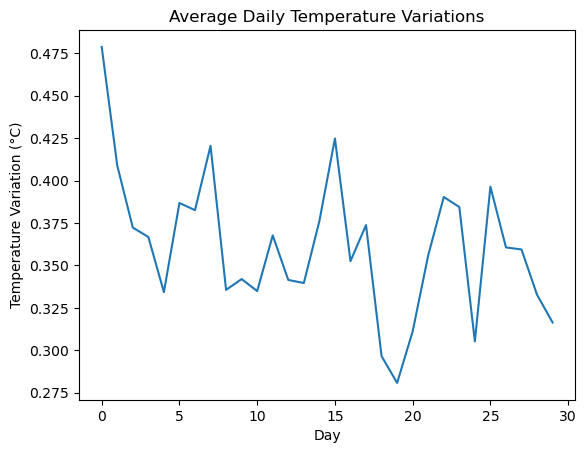

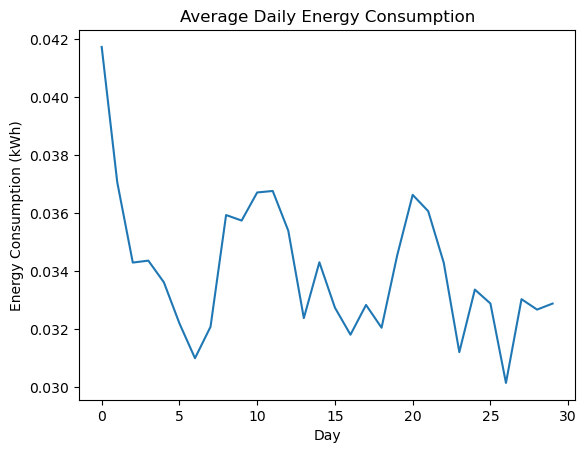

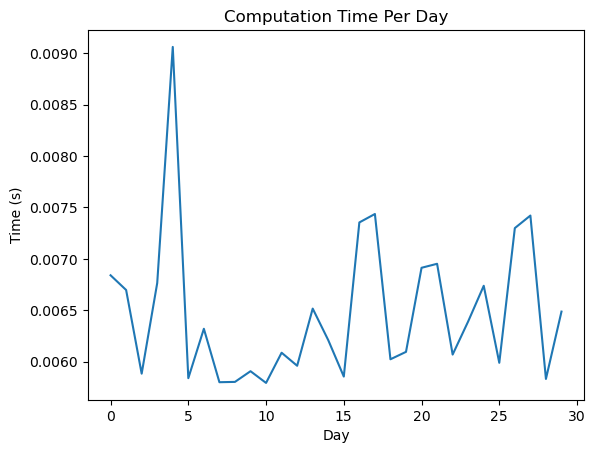

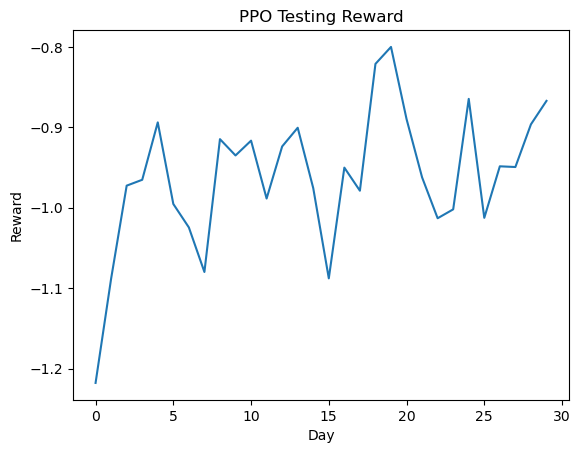

In [7]:
env.Stochasticity_Level=0
env.Stochastic_Testing=False
model_name = 'SAC'
month='January'

if model_name=='PPO':
    model = PPO("MlpPolicy", env, verbose=1)
    vec_env = model.get_env()
    model = PPO.load(f"PPO_{Building}_Deterministic_Reward{reward}")
elif model_name=='SAC':
    model = SAC("MlpPolicy", env, verbose=1)
    vec_env = model.get_env()
    model = SAC.load(f"SAC_{Building}_Deterministic_Reward{reward}_Final")
    
directory_name = f"{model_name}/{month}_{Building}_Deterministic_Reward{reward}"

# Create the directory
os.makedirs(directory_name, exist_ok=True)

# Print the path of the created directory
print(f"Directory '{directory_name}' created.")

# Lists to store the results
rewardlist = []
energy_consumptions = []
temperature_variations = []
computation_times = []
temp_data = []

obs = vec_env.reset()

print(obs)
if month=='January':
    month_index=0
elif month=='July':
    month_index=181
# Testing loop

for day in range(30+month_index):
    start_time = time.time()
    daily_temp_variations = []
    daily_energy_consumption = 0
    total_rewards = 0


    for hour in range(24):
        # Predict the action using the model
        action, _states = model.predict(obs, deterministic=True)  # Use deterministic during testing
                # Append temperature data along with timestamp
        if day>=month_index:
            for room_idx, temp_value in enumerate(obs[0][:roomnum]):
                temp_data.append({
                    'Day': day + 1,          # Days are 1-indexed
                    'Hour': hour,
                    'Room': room_idx + 1,    # Rooms are 1-indexed
                    'Temperature': temp_value
                })

            obs, rewards, dones, info = vec_env.step(action)
            total_rewards += rewards

        # Calculate temperature deviations and energy consumption
        state_new = obs[0][:roomnum]  # Temperatures for each room
        occ_info = obs[0][-roomnum:]  # Occupancy information
        print(occ_info)
        temp_deviations = calculate_temperature_deviations(state_new, occ_info, roomnum, env.target)
        daily_temp_variations.extend(temp_deviations)
        daily_energy_consumption += np.sum(np.abs(action))

        if day == 0 and hour == 23:
            print("total rewards", total_rewards/24)
            print("temp_deviations", np.mean(daily_temp_variations))



    if day>=month_index:
        # Store daily results
        computation_times.append(time.time() - start_time)
        rewardlist.append(total_rewards / 24)
        energy_consumptions.append(daily_energy_consumption / 1000)  # Convert to kWh
        temperature_variations.append(np.mean(daily_temp_variations) if daily_temp_variations else 0)

# Save the temperature data to a CSV file
temp_df = pd.DataFrame(temp_data)
temp_df.to_csv(f"{directory_name}/temperature_data.csv", index=False)

# Save the summary results to a CSV file
results_df = pd.DataFrame({
    'Computation Time (s)': computation_times,
    'Average Daily Temperature Variation (°C)': temperature_variations,
    'Average Daily Energy Consumption (kWh)': energy_consumptions,
    'Average Daily Reward': rewardlist,
})
results_df.to_csv(f"{directory_name}/{model_name}_testing_results.csv", index=False)


print("################ TESTING is Done ############")

# Plot and save results
plt.plot(temperature_variations)
plt.title('Average Daily Temperature Variations')
plt.xlabel('Day')
plt.ylabel('Temperature Variation (°C)')
#plt.savefig(f"{Building}_{occ_mode}_Reward{reward}/PPO_temp_variation_test.pdf")
plt.show()

plt.plot(energy_consumptions)
plt.title('Average Daily Energy Consumption')
plt.xlabel('Day')
plt.ylabel('Energy Consumption (kWh)')
#plt.savefig(f"{Building}_{occ_mode}_Reward{reward}/PPO_energy_consumption_test.pdf")
plt.show()

plt.plot(computation_times)
plt.title('Computation Time Per Day')
plt.xlabel('Day')
plt.ylabel('Time (s)')
#plt.savefig(f"{Building}_{occ_mode}_Reward{reward}/PPO_computation_time_test.pdf")
plt.show()

plt.plot(rewardlist)
plt.title('PPO Testing Reward')
plt.xlabel('Day')
plt.ylabel('Reward')
#plt.savefig(f"{Building}_{occ_mode}_Reward{reward}/PPO_reward_test.pdf")
plt.show()

### Testing SAC and PPO for stochastic occupancy. 

For this purpose we set env.Stochasticity_Level=1 and env.Stochastic_Testing=True in the environment to ensure that the testing happens in deterministic conditions. 
We run the cell below for different months (January, July) and models (PPO, SAC). We load the model trained in the previous cell for this purpose. 

Remember that this stochasticity is done by sampling occupancy presence and activities once at the beginning. Then, across each run, it uses a previously sampled data. This ensures that across different models, we use the same conditions to ensure fair comparison.

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Directory 'SAC/July_OfficeSmall_Stochastic_Reward3' created.
stochastic metabolism for testing has been loaded
Stochasticity Level 1
initial obs  [[22.  22.  22.  22.  22.  22.   5.6  0.   0.   0.   0.   0.   0.  20.9
   0.   0.   0.   0.   0.   0. ]]
[[22.  22.  22.  22.  22.  22.   5.6  0.   0.   0.   0.   0.   0.  20.9
   0.   0.   0.   0.   0.   0. ]]
obs [[22.  22.  22.  22.  22.  22.   5.6  0.   0.   0.   0.   0.   0.  20.9
   0.   0.   0.   0.   0.   0. ]]
stochastic occupancy state: [0. 0. 0. 0. 0. 0.]
obs [[ 8.011501   9.547121   7.9371495  9.337842   6.2446303 12.842334
   5.6        0.         0.         0.         0.         0.
   0.        20.9        0.         0.         0.         0.
   0.         0.       ]]
stochastic occupancy state: [0. 0. 0. 0. 0. 0.]
obs [[ 4.0997195  6.42692    6.9408183  6.438422   4.144807   9.485792
   4.6        0.         0.         0.         0.   

/Users/ozanbaris/anaconda3/envs/nesl/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ozanbaris/anaconda3/envs/nesl/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


stochastic occupancy state: [0. 0. 0. 0. 0. 0.]
obs [[ 5.7654424  6.228164   4.876987   5.247794   5.1798725  6.4839683
   7.         0.         0.         0.         0.         0.
   0.        20.9        0.         0.         0.         0.
   0.         0.       ]]
stochastic occupancy state: [0. 0. 0. 0. 0. 0.]
obs [[ 2.9594626  5.1067033  3.9293184  5.0456347  2.2002215  5.9166284
   8.         0.         0.         0.         0.         0.
   0.        20.9        0.         0.         0.         0.
   0.         0.       ]]
stochastic occupancy state: [0. 0. 0. 0. 0. 0.]
obs [[ 4.5779696  3.4538138  2.461633   5.396381   4.119167   5.742835
   9.         0.         0.         0.         0.         0.
   0.        20.9        0.         0.         0.         0.
   0.         0.       ]]
stochastic occupancy state: [0. 0. 0. 0. 0. 0.]
obs [[ 5.5414586  5.161296   6.521748   5.7911944  4.454588   7.93179
   7.         0.         0.         0.         0.         0.
   0.        20.9 

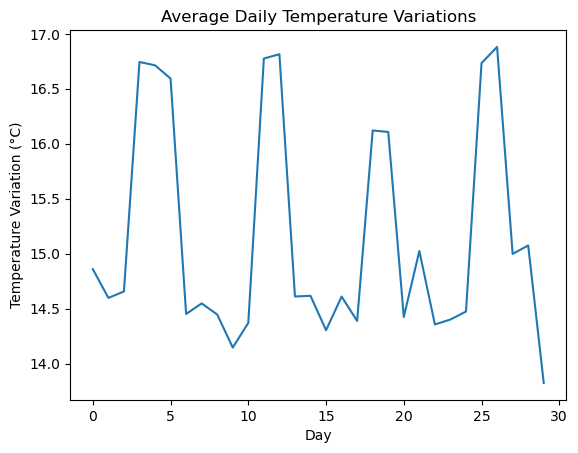

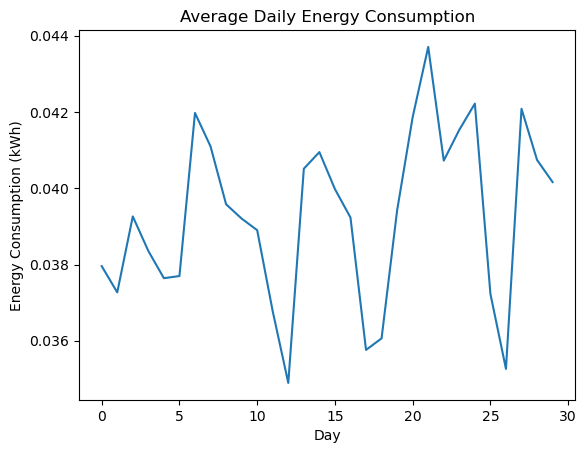

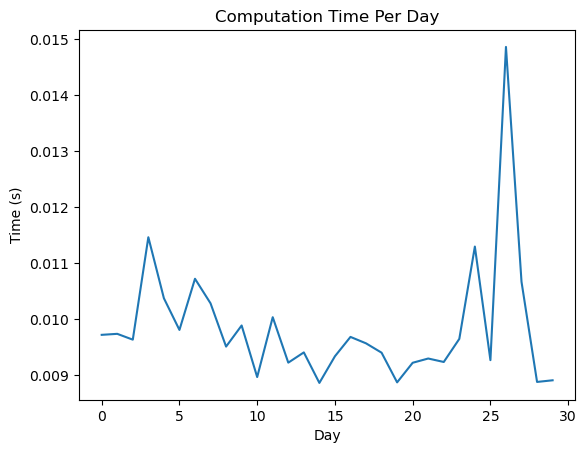

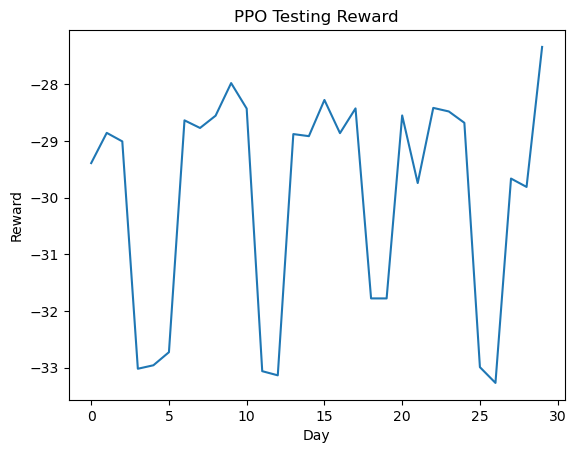

In [11]:

model_name='SAC'
month='July'

env.Stochasticity_Level=1
env.Stochastic_Testing=True
if model_name=='PPO':
    model = PPO("MlpPolicy", env, verbose=1)
    vec_env = model.get_env()
    model = PPO.load(f"PPO_{Building}_Deterministic_Reward{reward}")
elif model_name=='SAC':
    model = SAC("MlpPolicy", env, verbose=1)
    vec_env = model.get_env()
    model = SAC.load(f"SAC_{Building}_Deterministic_Reward{reward}_Final")


# Define the directory name
directory_name = f"{model_name}/{month}_{Building}_Stochastic_Reward{reward}"

# Create the directory
os.makedirs(directory_name, exist_ok=True)

# Print the path of the created directory
print(f"Directory '{directory_name}' created.")

# Lists to store the results
rewardlist = []
energy_consumptions = []
temperature_variations = []
computation_times = []
temp_data = []

obs = vec_env.reset()
print("initial obs ", obs)
print(obs)
if month=='January':
    month_index=0
elif month=='July':
    month_index=181

# Testing loop
for day in range(30+month_index):
    start_time = time.time()
    daily_temp_variations = []
    daily_energy_consumption = 0
    total_rewards = 0


    for hour in range(24):
        # Predict the action using the model
        print("obs", obs)
        action, _states = model.predict(obs)  # Use deterministic during testing
                # Append temperature data along with timestamp
        if day>=month_index:
            for room_idx, temp_value in enumerate(obs[0][:roomnum]):
                temp_data.append({
                    'Day': day + 1,          # Days are 1-indexed
                    'Hour': hour,
                    'Room': room_idx + 1,    # Rooms are 1-indexed
                    'Temperature': temp_value
                })

        obs, rewards, dones, info = vec_env.step(action)
        total_rewards += rewards

        if day>=month_index:
            # Calculate temperature deviations and energy consumption
            state_new = obs[0][:roomnum]  # Temperatures for each room
            occ_info = obs[0][-roomnum:]  # Occupancy information
            print(occ_info)
            temp_deviations = calculate_temperature_deviations(state_new, occ_info, roomnum, env.target)
            daily_temp_variations.extend(temp_deviations)
            daily_energy_consumption += np.sum(np.abs(action))

        if day == 0 and hour == 23:
            print("total rewards", total_rewards/24)
            print("temp_deviations", np.mean(daily_temp_variations))



    if day>=month_index:
        # Store daily results
        computation_times.append(time.time() - start_time)
        rewardlist.append(total_rewards / 24)
        energy_consumptions.append(daily_energy_consumption / 1000)  # Convert to kWh
        temperature_variations.append(np.mean(daily_temp_variations) if daily_temp_variations else 0)

# Save the temperature data to a CSV file
temp_df = pd.DataFrame(temp_data)
temp_df.to_csv(f"{directory_name}/temperature_data.csv", index=False)

# Save the summary results to a CSV file
results_df = pd.DataFrame({
    'Computation Time (s)': computation_times,
    'Average Daily Temperature Variation (°C)': temperature_variations,
    'Average Daily Energy Consumption (kWh)': energy_consumptions,
    'Average Daily Reward': rewardlist,
})
results_df.to_csv(f"{directory_name}/{model_name}_testing_results.csv", index=False)


print("################ TESTING is Done ############")

# Plot and save results
plt.plot(temperature_variations)
plt.title('Average Daily Temperature Variations')
plt.xlabel('Day')
plt.ylabel('Temperature Variation (°C)')
#plt.savefig(f"{Building}_{occ_mode}_Reward{reward}/PPO_temp_variation_test.pdf")
plt.show()

plt.plot(energy_consumptions)
plt.title('Average Daily Energy Consumption')
plt.xlabel('Day')
plt.ylabel('Energy Consumption (kWh)')
#plt.savefig(f"{Building}_{occ_mode}_Reward{reward}/PPO_energy_consumption_test.pdf")
plt.show()

plt.plot(computation_times)
plt.title('Computation Time Per Day')
plt.xlabel('Day')
plt.ylabel('Time (s)')
#plt.savefig(f"{Building}_{occ_mode}_Reward{reward}/PPO_computation_time_test.pdf")
plt.show()

plt.plot(rewardlist)
plt.title('PPO Testing Reward')
plt.xlabel('Day')
plt.ylabel('Reward')
#plt.savefig(f"{Building}_{occ_mode}_Reward{reward}/PPO_reward_test.pdf")
plt.show()

### Plotting results

In the cell below, we plot the results of different energy and temperature metrics for the 4 conditions we had trained for. 

reading data from SAC/January_OfficeSmall_Stochastic_Reward3/SAC_testing_results.csv
reading data from SAC/January_OfficeSmall_Deterministic_Reward3/SAC_testing_results.csv
reading data from PPO/January_OfficeSmall_Stochastic_Reward3/PPO_testing_results.csv
File not found for OfficeSmall, Stochastic, reward 3, month January
reading data from PPO/January_OfficeSmall_Deterministic_Reward3/PPO_testing_results.csv
File not found for OfficeSmall, Deterministic, reward 3, month January
reading data from SAC/January_OfficeSmall_Stochastic_Reward3/SAC_testing_results.csv
reading data from SAC/January_OfficeSmall_Deterministic_Reward3/SAC_testing_results.csv
reading data from PPO/January_OfficeSmall_Stochastic_Reward3/PPO_testing_results.csv
File not found for OfficeSmall, Stochastic, reward 3, month January
reading data from PPO/January_OfficeSmall_Deterministic_Reward3/PPO_testing_results.csv
File not found for OfficeSmall, Deterministic, reward 3, month January
reading data from SAC/July_Off

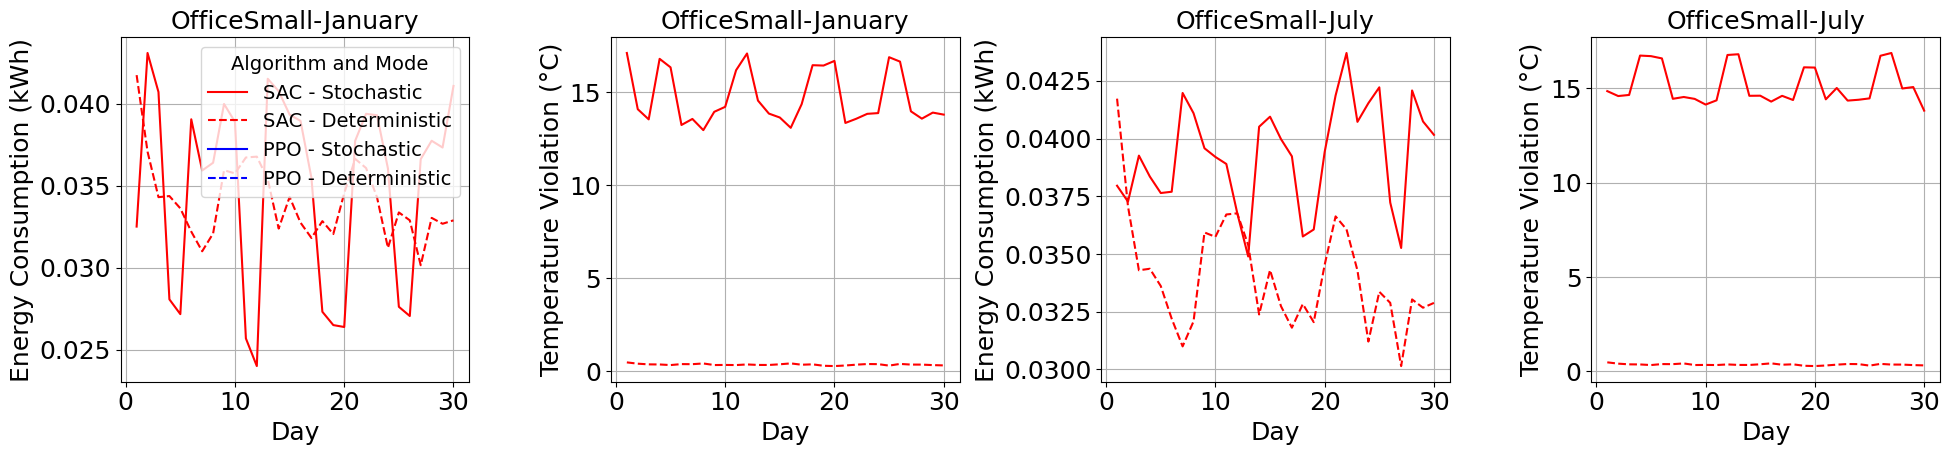

In [ ]:

def plot_existing_bear(building, algorithms, occ_modes, reward):
    """
    Plots temperature violation and energy consumption metrics across days for each occupancy mode
    and algorithm in a single figure with 4 columns and 1 row. The columns represent:
    - OfficeSmall-January for energy
    - OfficeSmall-July for energy
    - OfficeSmall-January for temperature
    - OfficeSmall-July for temperature

    Args:
        building (str): The name of the building type.
        algorithms (list): List of algorithms to compare (e.g., ['PPO', 'A2C']).
        occ_modes (list): List of occupancy modes to compare (e.g., ['Stochastic', 'Deterministic']).
        reward (int): Reward type (e.g., 1, 2).

    Returns:
        None
    """
    # Define colors for each algorithm
    algorithm_colors = {
        'PPO': 'blue',
        'A2C': 'green',
        'SAC': 'red'
    }

    # Define months and metric types for the subplots
    subplots_info = [
        {'month': 'January', 'metric_type': 'energy'},
        {'month': 'January', 'metric_type': 'temperature'},
        {'month': 'July', 'metric_type': 'energy'},
        {'month': 'July', 'metric_type': 'temperature'}
    ]

    # Create a figure with 1 row and 4 columns
    fig, axes = plt.subplots(nrows=1, ncols=4, 
                             
                              sharey=False)

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1)

    # Loop through each subplot and plot the data
    for idx, info in enumerate(subplots_info):
        month = info['month']
        metric_type = info['metric_type']
        ax = axes[idx]

        # Data to store all metrics for the algorithms
        data = []

        # Iterate through each algorithm and occupancy mode to collect the data
        for algorithm in algorithms:
            for occ_mode in occ_modes:
                file_path = f"{algorithm}/{month}_{building}_{occ_mode}_Reward{reward}/{algorithm}_testing_results.csv"
                print("reading data from", file_path)
                if os.path.exists(file_path):
                    df = pd.read_csv(file_path)

                    # Choose the appropriate metric based on the metric_type
                    if metric_type == 'energy':
                        metric = 'Average Daily Energy Consumption (kWh)'
                        ylabel = 'Energy Consumption (kWh)'
                    elif metric_type == 'temperature':
                        # Find the column that contains the word "Temperature Violation"
                        temp_columns = [col for col in df.columns if 'Temperature' in col]
                        if temp_columns:
                            metric = temp_columns[0]  # Choose the first matching temperature column
                        else:
                            print(f"No temperature violation column found in {file_path}. Skipping.")
                            continue
                        ylabel = 'Temperature Violation (°C)'
                    else:
                        print(f"Unknown metric type: {metric_type}")
                        continue

                    # Ensure that the selected metric exists in the DataFrame
                    if metric in df.columns:
                        for day, value in enumerate(df[metric]):
                            data.append({
                                'Day': day + 1,
                                'Occupancy Mode': occ_mode,  # Use mode name directly without mapping
                                'Algorithm': algorithm,
                                'Metric': value
                            })
                    else:
                        print(f"Metric '{metric}' not found in {file_path}")
                else:
                    print(f"File not found for {building}, {occ_mode}, reward {reward}, month {month}")

        if not data:
            print(f"No data available to plot for {month} - {metric_type}.")
            continue

        # Create a DataFrame from the collected data
        results_df = pd.DataFrame(data)

        # Plot data for each algorithm
        for algorithm in algorithms:
            for occ_mode in occ_modes:
                linestyle = '--' if occ_mode == 'Deterministic'  else '-'
                subset = results_df[(results_df['Algorithm'] == algorithm) & 
                                    (results_df['Occupancy Mode'] == occ_mode)]
                sns.lineplot(
                    x='Day',
                    y='Metric',
                    data=subset,
                    ax=ax,
                    label=f"{algorithm} - {occ_mode}",
                    color=algorithm_colors[algorithm],
                    linestyle=linestyle
                )

        # Customizing the subplot with larger font sizes
        ax.set_title(f'{building}-{month}', fontsize=18)
        ax.set_xlabel('Day', fontsize=18)
        ax.set_ylabel(ylabel, fontsize=18)
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=18)
        ax.grid(True)

        # Only add legend to the first subplot
        if idx == 0:
            ax.legend(title='Algorithm and Mode', fontsize=14, title_fontsize=14, loc='upper right')
        else:
            ax.legend_.remove()

    # Adjust layout
    plt.tight_layout(rect=[0.02, 0.02, 1, 0.95])

    # Save and show the figure
    plt.savefig(f"existing_bear_{reward}.pdf")
    plt.show()
reward=3
# Define the combinations of buildings, rewards, and metric types
building = 'OfficeSmall'
algorithms = ['SAC','PPO']
occ_modes = ['Stochastic', 'Deterministic']
rewards = [reward]

# Loop through each reward and plot the metrics
for reward in rewards:
    plot_existing_bear(building, algorithms, occ_modes, reward)


In [13]:

def compute_percent_increase(building, algorithms, occ_modes, reward, months):
    """
    Computes the percent increase from deterministic to stochastic cases for 
    energy consumption and temperature variation for each algorithm and month.

    Args:
        building (str): The name of the building type.
        algorithms (list): List of algorithms to compare (e.g., ['PPO', 'A2C']).
        occ_modes (list): List of occupancy modes (should include 'Stochastic' and 'Deterministic').
        reward (int): Reward type (e.g., 1, 2).
        months (list): List of months to compare (e.g., ['January', 'July']).

    Returns:
        None
    """
    results = []

    for month in months:
        for algorithm in algorithms:
            # File paths for Stochastic and Deterministic cases
            data = {}
            for occ_mode in occ_modes:
                file_path = f"{algorithm}/{month}_{building}_{occ_mode}_Reward{reward}/{algorithm}_testing_results.csv"
                if os.path.exists(file_path):
                    df = pd.read_csv(file_path)
                    
                    # Extract metrics
                    energy_metric = 'Average Daily Energy Consumption (kWh)'
                    temp_metric = 'Average Daily Temperature Variation (°C)'

                    if energy_metric in df.columns and temp_metric in df.columns:
                        data[occ_mode] = {
                            'energy': df[energy_metric].mean(),
                            'temperature': df[temp_metric].mean()
                        }
                    else:
                        print(f"Metrics not found in {file_path}")
                else:
                    print(f"File not found: {file_path}")

            # Compute percent increases if both modes are available
            if 'Stochastic' in data and 'Deterministic' in data:
                energy_deterministic = data['Deterministic']['energy']
                energy_stochastic = data['Stochastic']['energy']
                temp_deterministic = data['Deterministic']['temperature']
                temp_stochastic = data['Stochastic']['temperature']

                energy_percent_increase = ((energy_stochastic - energy_deterministic) / energy_deterministic) * 100
                temp_percent_increase = ((temp_stochastic - temp_deterministic) / temp_deterministic) * 100

                results.append({
                    'Algorithm': algorithm,
                    'Month': month,
                    'Energy Percent Increase (%)': energy_percent_increase,
                    'Temperature Percent Increase (%)': temp_percent_increase
                })
            else:
                print(f"Missing data for {algorithm} in {month}")

    # Convert results to a DataFrame and print
    results_df = pd.DataFrame(results)
    print("\nPercent Increase Results:")
    print(results_df)

# Example usage
building = 'OfficeSmall'
algorithms = ['PPO','SAC']
occ_modes = ['Stochastic', 'Deterministic']
reward = 3
months = ['January', 'July']

compute_percent_increase(building, algorithms, occ_modes, reward, months)


File not found: PPO/January_OfficeSmall_Stochastic_Reward3/PPO_testing_results.csv
File not found: PPO/January_OfficeSmall_Deterministic_Reward3/PPO_testing_results.csv
Missing data for PPO in January
File not found: PPO/July_OfficeSmall_Stochastic_Reward3/PPO_testing_results.csv
File not found: PPO/July_OfficeSmall_Deterministic_Reward3/PPO_testing_results.csv
Missing data for PPO in July

Percent Increase Results:
  Algorithm    Month  Energy Percent Increase (%)  \
0       SAC  January                     2.616339   
1       SAC     July                    15.413471   

   Temperature Percent Increase (%)  
0                       3976.284401  
1                       4098.438825  


In [40]:
import pandas as pd
import os
import numpy as np
import re

def extract_numbers_from_string(s):
    """
    Extracts all floating-point numbers from a string.

    Args:
        s (str): The string containing numbers.

    Returns:
        list: A list of floating-point numbers.
    """
    # Use non-capturing groups to avoid empty strings
    numbers = re.findall(r'-?\d+\.\d+(?:e[+-]?\d+)?', s)
    numbers = [float(num) for num in numbers]
    return numbers

def create_summary_table_officesmall(model_name, reward, metrics, months):
    """
    Creates a summary table showing various metrics for Stochastic-I and Stochastic-II occupancy modes,
    relative to the Deterministic (Existing) mode for the OfficeSmall building, for each month.

    Args:
        reward (list): List of rewards (e.g., [1, 2]).
        metrics (list): List of metrics to compute.
        months (list): List of months to process (e.g., ['January', 'July']).

    Returns:
        DataFrame: A table with average values, standard deviation, and percent increase
        for each occupancy mode and metric, for each month.
    """
    # Define the occupancy modes and rename mapping
    occ_modes = ['Stochastic', 'Deterministic']

    # Create a list to store the results
    summary_data = []

    # Iterate through the rewards, months, and metrics
    for r in reward:
        for month in months:
            for metric in metrics:
                means = {}
                stds = {}

                # Collect the mean and standard deviation for each occupancy mode
                for occ_mode in occ_modes:
                    file_path = f"{model_name}/{month}_OfficeSmall_{occ_mode}_Reward{r}/{model_name}_testing_results.csv"
                    #print("reading data from", file_path)
                    if os.path.exists(file_path):
                        df = pd.read_csv(file_path)
                        #print("data is read", df)
                        if metric in df.columns:
                            if metric == 'Average Daily Reward':
                                # Process the 'Average Daily Reward' column
                                values_list = []
                                for value in df[metric]:
                                    if isinstance(value, str):
                                        numbers = extract_numbers_from_string(value)
                                        values_list.extend(numbers)
                                    elif isinstance(value, (int, float, np.number)):
                                        # If the value is already numeric
                                        values_list.append(float(value))
                                    else:
                                        print(f"Unrecognized data type in 'Average Daily Reward': {value}")
                                # Now compute mean and std over values_list
                                if values_list:
                                    means[occ_mode] = np.mean(values_list)
                                    stds[occ_mode] = np.std(values_list)
                                else:
                                    print(f"No valid numbers found in 'Average Daily Reward' for {occ_mode}")
                                    means[occ_mode] = np.nan
                                    stds[occ_mode] = np.nan
                            else:
                                # Try to convert the column to numeric
                                df[metric] = pd.to_numeric(df[metric], errors='coerce')
                                means[occ_mode] = df[metric].mean()
                                stds[occ_mode] = df[metric].std()
                        else:
                            print(f"Metric '{metric}' not found in {file_path}")
                    else:
                        print(f"File not found: {file_path}")

                # If data exists for all occupancy modes, calculate percent increase and add it to the table
                if len(means) == 2:
                    deterministic_mean = means['Deterministic']
                    if deterministic_mean != 0 and not np.isnan(deterministic_mean):
                        percent_increase_stochastic = ((means['Stochastic'] - deterministic_mean) / abs(deterministic_mean)) * 100
                    else:
                        percent_increase_stochastic = np.nan

                    # Append data to summary
                    summary_data.append({
                        'Reward': r,
                        'Month': month,
                        'Metric': metric,
                        'Deterministic Mean ': means['Deterministic'],
                        'Deterministic Std': stds['Deterministic'],
                        'Stochastic Mean ': means['Stochastic'],
                        'Stochastic Std ': stds['Stochastic'],
                        'Percent Increase Stochastic': percent_increase_stochastic,
                    })
                else:
                    print(f"Data incomplete for Reward {r}, Month {month}, Metric {metric}. Skipping.")

    # Create a DataFrame from the collected data
    summary_df = pd.DataFrame(summary_data)

    # Display the summary table
    return summary_df

# Example usage
reward = [3]
metrics = [
    'Average Daily Energy Consumption (kWh)',
    'Average Daily Temperature Variation (°C)',
    'Average Daily Reward',
    'Computation Time (s)'
]
months = ['January', 'July']
model_name = 'SAC'
summary_table_officesmall = create_summary_table_officesmall(model_name,reward, metrics, months)
print(summary_table_officesmall)


   Reward    Month                                    Metric  \
0       3  January    Average Daily Energy Consumption (kWh)   
1       3  January  Average Daily Temperature Variation (°C)   
2       3  January                      Average Daily Reward   
3       3  January                      Computation Time (s)   
4       3     July    Average Daily Energy Consumption (kWh)   
5       3     July  Average Daily Temperature Variation (°C)   
6       3     July                      Average Daily Reward   
7       3     July                      Computation Time (s)   

   Deterministic Mean   Deterministic Std  Stochastic Mean   Stochastic Std   \
0             0.031049           0.002482          0.035013         0.007181   
1             0.355425           0.051740         14.076026         1.241685   
2            -0.947610           0.099175        -27.847514         2.358515   
3             0.006273           0.000417          0.009840         0.000826   
4             0.031049 

/var/folders/q5/xbcszlgx0s78ry5h1wzcd5qc0000gn/T/ipykernel_3733/1694765545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day1_room['Occupancy Mode'] = occ_mode
/var/folders/q5/xbcszlgx0s78ry5h1wzcd5qc0000gn/T/ipykernel_3733/1694765545.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day1_room['Room'] = room_num
/var/folders/q5/xbcszlgx0s78ry5h1wzcd5qc0000gn/T/ipykernel_3733/1694765545.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

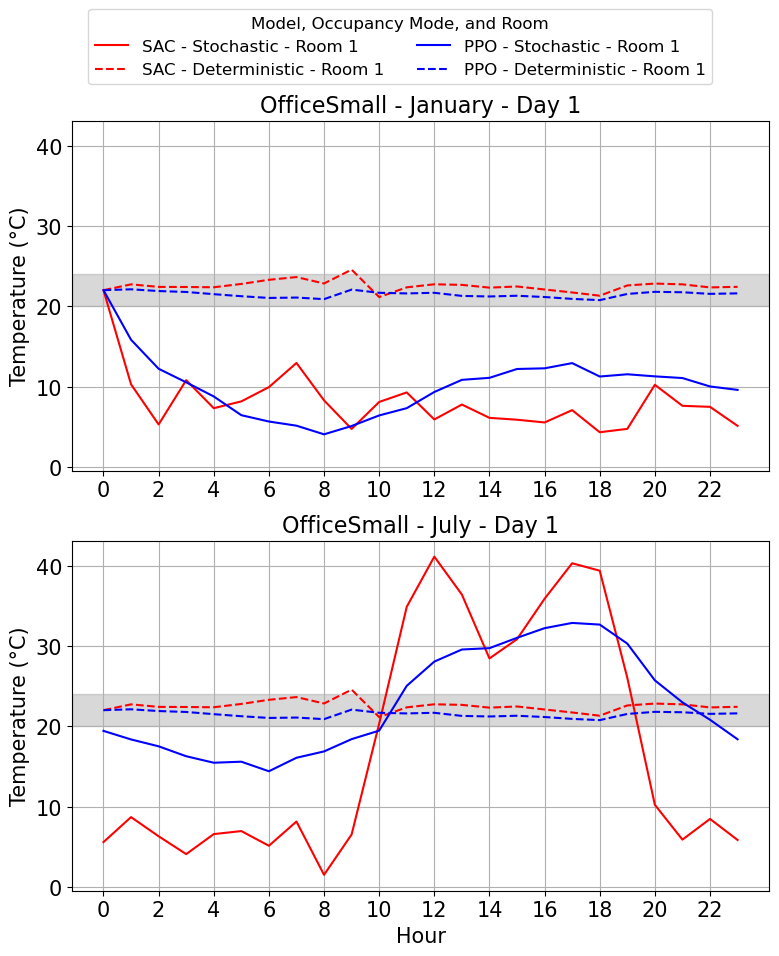

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

def plot_temperature_selected_rooms(building, models, occ_modes, reward):
    """
    Plots temperature data for Room 1, Room 3, and Room 6 across different models and occupancy modes
    in a single figure with subplots for January and July, arranged vertically with
    a shared legend located outside at the top.

    Args:
        building (str): The name of the building type.
        models (list): List of model names to compare (e.g., ['SAC', 'PPO']).
        occ_modes (list): List of occupancy modes to compare (e.g., ['Stochastic', 'Deterministic']).
        reward (int): Reward type (e.g., 1, 2).

    Returns:
        None
    """

    # Define colors for each model
    model_colors = {
        'SAC': 'red',
        'PPO': 'blue'
    }

    # Define line styles for occupancy modes
    linestyles = {
        'Deterministic': '--',
        'Stochastic': '-'
    }

    # Define months for the subplots
    months = ['January', 'July']

    # Create a figure with 2 rows and 1 column for January and July
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 10), sharey=True)

    # Data to store the line objects for the legend
    line_labels = []

    # Loop through each month and plot the data
    for idx, month in enumerate(months):
        ax = axes[idx]

        # Data to store all model and occupancy mode temperature data
        data = []

        # Iterate through each model and occupancy mode to collect the data
        for model in models:
            for occ_mode in occ_modes:
                # Adjusted file path to match the directory structure
                directory_name = f"{model}/{month}_{building}_{occ_mode}_Reward{reward}"
                file_path = f"{directory_name}/temperature_data.csv"
                if os.path.exists(file_path):
                    df = pd.read_csv(file_path)

                    # Loop through selected rooms (Room 1, Room 3, Room 6)
                    for room_num in [1, 3, 6]:
                        if month == 'January':
                            df_day1_room = df[(df['Day'] == 1) & (df['Room'] == room_num)]
                        else:
                            df_day1_room = df[(df['Day'] == 182) & (df['Room'] == room_num)]
                        
                        if not df_day1_room.empty:
                            # Append data with occupancy mode, room number, and model
                            df_day1_room['Occupancy Mode'] = occ_mode
                            df_day1_room['Room'] = room_num
                            df_day1_room['Model'] = model
                            data.append(df_day1_room)
                        else:
                            print(f"No data for Day 1, Room {room_num} in {file_path}")
                else:
                    print(f"File not found for {building}, {model}, {occ_mode}, reward {reward}, month {month}")

        if not data:
            print(f"No data available to plot for {month}.")
            continue

        # Concatenate data from all models, occupancy modes, and rooms
        results_df = pd.concat(data)

        # Plotting the temperature over hours for each model, occupancy mode, and selected rooms
        for model in models:
            for occ_mode in occ_modes:
                for room_num in [1]:
                    room_data = results_df[
                        (results_df['Model'] == model) & 
                        (results_df['Occupancy Mode'] == occ_mode) & 
                        (results_df['Room'] == room_num)
                    ]
                    line = sns.lineplot(
                        x='Hour',
                        y='Temperature',
                        data=room_data,
                        label=f'{model} - {occ_mode} - Room {room_num}',
                        color=model_colors[model],
                        linestyle=linestyles[occ_mode],
                        ax=ax
                    )
                    # Append the line to the list of line objects for the legend
                    line_labels.append(line)

        # Add grey shaded area between y=20 and y=24
        ax.axhspan(20, 24, color='grey', alpha=0.3)

        # Customizing the subplot with larger font sizes
        ax.set_title(f'{building} - {month} - Day 1', fontsize=16)
        if idx == 1:
            ax.set_xlabel('Hour', fontsize=15)
        else:
            ax.set_xlabel('')
        ax.set_ylabel('Temperature (°C)', fontsize=15)
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)
        ax.grid(True)
        ax.set_xticks(range(0, 24, 2))
        ax.legend_.remove()

    # Create a single legend for all plots
    handles, labels = ax.get_legend_handles_labels()  # Get handles and labels
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.49, 1.00001), ncol=2, fontsize=12, title="Model, Occupancy Mode, and Room", title_fontsize=12)

    # Adjust layout to leave space for the legend
    plt.subplots_adjust(top=0.88)  # Adjust this value as needed to give space for the legend

    # Save and show the figure
    plt.savefig(f"temperature_day1_reward_{reward}_rooms_1_3_6_vertical.pdf", bbox_inches='tight')
    plt.show()

# Define the combinations of buildings, rewards, models, and occupancy modes
building = 'OfficeSmall'
models = ['SAC', 'PPO']
occ_modes = ['Stochastic', 'Deterministic']
reward = 3  # You can change this to 2 if needed

# Plot the temperature data for Room 1, Room 3, and Room 6
plot_temperature_selected_rooms(building, models, occ_modes, reward)


In [ ]:
#read PPO_training_results.csv
df = pd.read_csv("PPO_training_results.csv")
print(df.head())
rew=[]

for rew in df['Average Daily Reward'].values():
    rew.append

   Computation Time (s)  Average Daily Temperature Variation (°C)  \
0              4.907183                                 10.329189   
1              4.892421                                  7.152583   
2              4.330686                                  7.402887   
3              4.267028                                  7.701589   
4              4.311546                                  7.997867   

   Average Daily Energy Consumption (kWh) Average Daily Reward  
0                           735861.286163         [-22.508978]  
1                           727178.565979         [-15.906508]  
2                           688947.952271         [-16.780567]  
3                           732743.089676         [-17.122892]  
4                           636402.150154         [-17.526108]  


In [1]:
import re
import pandas as pd
def extract_numbers_from_string(s):
    """
    Extracts all floating-point numbers from a string.

    Args:
        s (str): The string containing numbers.

    Returns:
        list: A list of floating-point numbers.
    """
    # Use non-capturing groups to avoid empty strings
    numbers = re.findall(r'-?\d+\.\d+(?:e[+-]?\d+)?', s)
    numbers = [float(num) for num in numbers]
    return numbers

#read PPO_training_results.csv
df = pd.read_csv("PPO_training_results.csv")

# Process the 'Average Daily Reward' column
values_list = []
for value in df['Average Daily Reward']:
    if isinstance(value, str):
        numbers = extract_numbers_from_string(value)
        values_list.extend(numbers)
    elif isinstance(value, (int, float, np.number)):
        # If the value is already numeric
        values_list.append(float(value))
    else:
        print(f"Unrecognized data type in 'Average Daily Reward': {value}")

ppo_rewards=values_list

In [2]:
import re
def extract_numbers_from_string(s):
    """
    Extracts all floating-point numbers from a string.

    Args:
        s (str): The string containing numbers.

    Returns:
        list: A list of floating-point numbers.
    """
    # Use non-capturing groups to avoid empty strings
    numbers = re.findall(r'-?\d+\.\d+(?:e[+-]?\d+)?', s)
    numbers = [float(num) for num in numbers]
    return numbers

#read PPO_training_results.csv
df = pd.read_csv("SAC_training_results.csv")

# Process the 'Average Daily Reward' column
values_list = []
for value in df['Average Daily Reward']:
    if isinstance(value, str):
        numbers = extract_numbers_from_string(value)
        values_list.extend(numbers)
    elif isinstance(value, (int, float, np.number)):
        # If the value is already numeric
        values_list.append(float(value))
    else:
        print(f"Unrecognized data type in 'Average Daily Reward': {value}")

sac_rewards=values_list

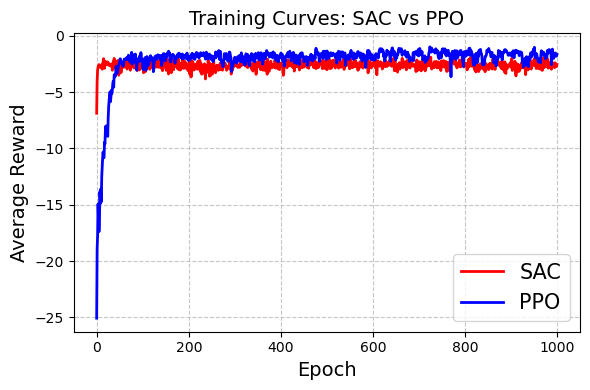

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))  # Correctly setting the figure size
plt.plot(sac_rewards, color='red', label='SAC', linestyle='-', linewidth=2)
plt.plot(ppo_rewards, color='blue', label='PPO', linestyle='-', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Average Reward', fontsize=14)
plt.title('Training Curves: SAC vs PPO', fontsize=14)
plt.legend(fontsize=15, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjusting layout for better spacing
#save fig
plt.savefig("training_curves.pdf")
plt.show()